In [7]:
import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from utils import get_price, get_stables_mcap, get_staking_rewards, get_tvl, merge_df

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [8]:
tvl_data = ['data/algorand.csv', 'data/aptos.csv', 'data/cardano.csv', 'data/icp.csv', 
            'data/near.csv', 'data/solana.csv', 'data/sui.csv', 'data/tezos.csv']

price_data = ['price/algo_usd.csv', 'price/apt_usd.csv', 'price/ada_usd.csv', 'price/icp_usd.csv',
              'price/near_usd.csv', 'price/sol_usd.csv', 'price/sui_usd.csv', 'price/xtz_usd.csv']

stables_data = ['algorand.csv', 'aptos.csv', 'cardano.csv', 'icp.csv', 
                'near.csv', 'solana.csv', 'sui.csv', 'tezos.csv']


staking_data = ['algorand.json', 'aptos.json', 'cardano.json', 'icp.json',
                'near.json', 'solana.json', 'sui.json',  'tezos.json']

chain_names = ['Algorand', 'Aptos', 'Cardano', 'ICP', 
               'NEAR', 'Solana', 'Sui', 'Tezos']

In [9]:
tvl = get_tvl('Algorand', tvl_data[0])
price = get_price(price_data[0])
stable = get_stables_mcap(stables_data[0])
staking = get_staking_rewards(staking_data[0])

algorand = merge_df(tvl, price, stable, staking)
algorand.head()

,Date,TVL,price,market_cap,total_volume,StablesMCap,StakingRewards,Liquidity
0,2024-01-01,1.784498e+08,0.222787,1.785306e+09,5.351038e+07,76665763.0,6.732992,2.997267
1,2024-01-02,1.719526e+08,0.239103,1.915784e+09,5.211293e+07,76901590.0,6.732992,2.720189
2,2024-01-03,1.340282e+08,0.227055,1.809791e+09,9.068086e+07,77568514.0,6.732992,5.010571
3,2024-01-04,1.140867e+08,0.204838,1.636478e+09,1.390071e+08,76971987.0,6.732992,8.494288
4,2024-01-05,1.060972e+08,0.207506,1.661721e+09,6.730042e+07,77780946.0,6.732992,4.050043


In [68]:
X = algorand[['TVL', 'StablesMCap', 'StakingRewards', 'Liquidity']]
y = algorand['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [69]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = linear_model.predict(X_test)

# Calculate R^2 for the linear model
r2_linear = r2_score(y_test, y_pred_linear)
print(f'Linear Model R^2: {r2_linear:.2f}')

Linear Model R^2: 0.80


In [70]:
list(zip(X, linear_model.coef_)), linear_model.intercept_

([('TVL', 3.6359252726892474e-10),
  ('StablesMCap', -1.4990663182069076e-09),
  ('StakingRewards', 0.02007742980646063),
  ('Liquidity', 0.0010401987254951756)],
 0.13748160291148095)

In [82]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Fit the polynomial regression model
poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)

# Predict on the test set
y_pred_poly = poly_model.predict(X_poly_test)

# Calculate R^2 for the polynomial model
r2_poly = r2_score(y_test, y_pred_poly)
print(f'Polynomial Model R^2: {r2_poly:.2f}')


Polynomial Model R^2: 0.85


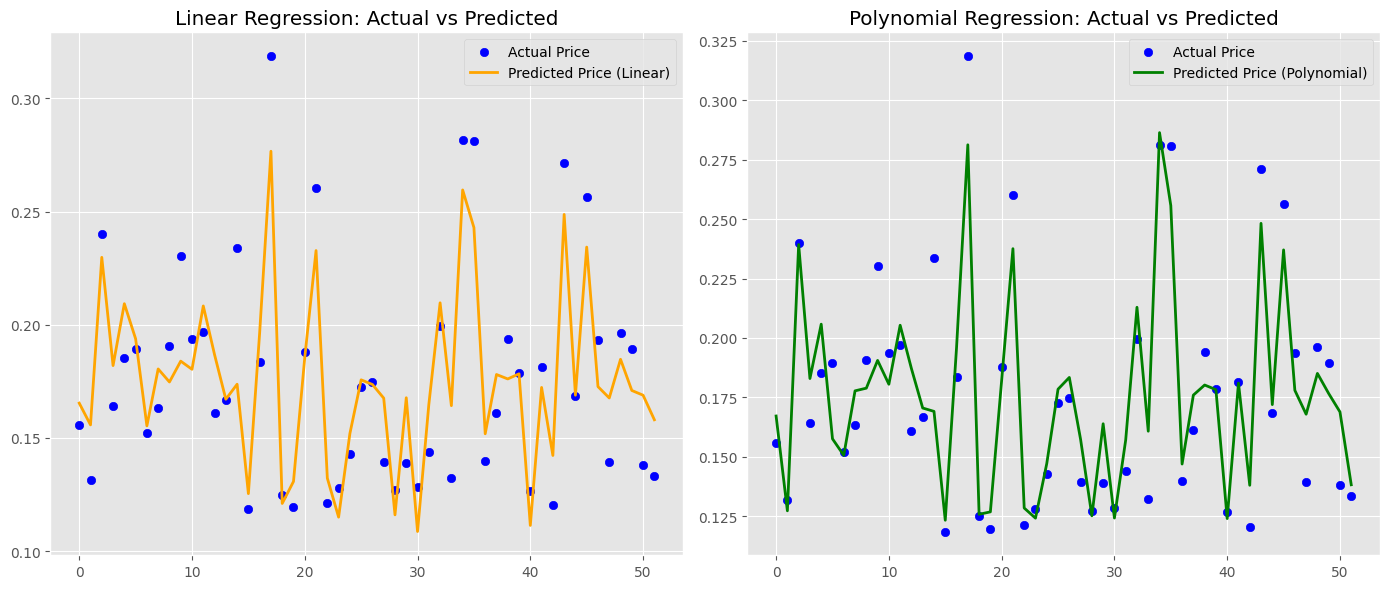

In [73]:
# Scatter plots and regression lines for the full set of variables
plt.figure(figsize=(14, 6))

# Scatter Plot of Actual vs Predicted for Linear Model
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Price')
plt.plot(range(len(y_pred_linear)), y_pred_linear, color='orange', label='Predicted Price (Linear)', linewidth=2)
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()

# Scatter Plot of Actual vs Predicted for Polynomial Model
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Price')
plt.plot(range(len(y_pred_poly)), y_pred_poly, color='green', label='Predicted Price (Polynomial)', linewidth=2)
plt.title('Polynomial Regression: Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()

Subset Linear Model R^2: 0.59
Subset Polynomial Model R^2: 0.66


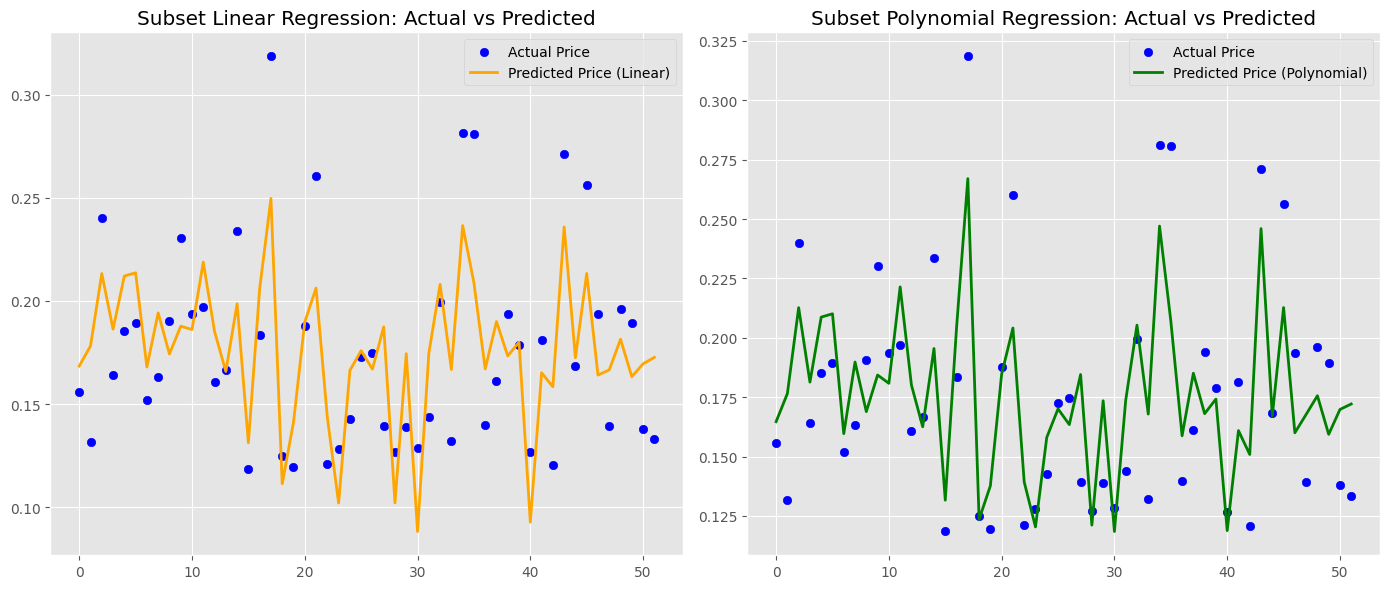

In [35]:
# Using only 'StablesMCap' and 'StakingRewards'
X_subset = algorand[['StablesMCap', 'StakingRewards']]
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y, test_size=0.2, random_state=42)

# Linear Regression on subset
linear_model_subset = LinearRegression()
linear_model_subset.fit(X_train_subset, y_train_subset)
y_pred_linear_subset = linear_model_subset.predict(X_test_subset)
r2_linear_subset = r2_score(y_test_subset, y_pred_linear_subset)
print(f'Subset Linear Model R^2: {r2_linear_subset:.2f}')

# Polynomial Regression on subset
X_poly_train_subset = poly.fit_transform(X_train_subset)
X_poly_test_subset = poly.transform(X_test_subset)

poly_model_subset = LinearRegression()
poly_model_subset.fit(X_poly_train_subset, y_train_subset)
y_pred_poly_subset = poly_model_subset.predict(X_poly_test_subset)
r2_poly_subset = r2_score(y_test_subset, y_pred_poly_subset)
print(f'Subset Polynomial Model R^2: {r2_poly_subset:.2f}')

# Scatter plots and regression lines for the subset of variables
plt.figure(figsize=(14, 6))

# Scatter Plot of Actual vs Predicted for Linear Model with Subset
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test_subset)), y_test_subset, color='blue', label='Actual Price')
plt.plot(range(len(y_pred_linear_subset)), y_pred_linear_subset, color='orange', label='Predicted Price (Linear)', linewidth=2)
plt.title('Subset Linear Regression: Actual vs Predicted')
plt.legend()

# Scatter Plot of Actual vs Predicted for Polynomial Model with Subset
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test_subset)), y_test_subset, color='blue', label='Actual Price')
plt.plot(range(len(y_pred_poly_subset)), y_pred_poly_subset, color='green', label='Predicted Price (Polynomial)', linewidth=2)
plt.title('Subset Polynomial Regression: Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
def fit_linear_model(X_train, y_train):
    # Fit the linear regression model
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    return linear_model

def fit_polynomial_model(X_train, y_train, degree=2):
    # Transform features to polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly_train = poly.fit_transform(X_train)
    
    # Fit the polynomial regression model
    poly_model = LinearRegression()
    poly_model.fit(X_poly_train, y_train)
    return poly_model, poly

def plot_regression_line(ax, X_test, y_test, y_pred, title, label='Linear'):
    # Scatter plot of actual values
    ax.scatter(range(len(y_test)), y_test, color='blue', label='Actual Price')
    
    # Plot regression line
    ax.plot(range(len(y_pred)), y_pred, color='orange', label=f'Predicted Price ({label})', linewidth=2)
    
    # Set title and legend
    ax.set_title(title)
    ax.legend()
    



In [60]:
datasets = {}

for token in chain_names:
    file_idx = chain_names.index(token)
    tvl = get_tvl(token, tvl_data[file_idx])
    price = get_price(price_data[file_idx])
    stable = get_stables_mcap(stables_data[file_idx])
    staking = get_staking_rewards(staking_data[file_idx])
    final_df = merge_df(tvl, price, stable, staking)
    datasets[token] = final_df

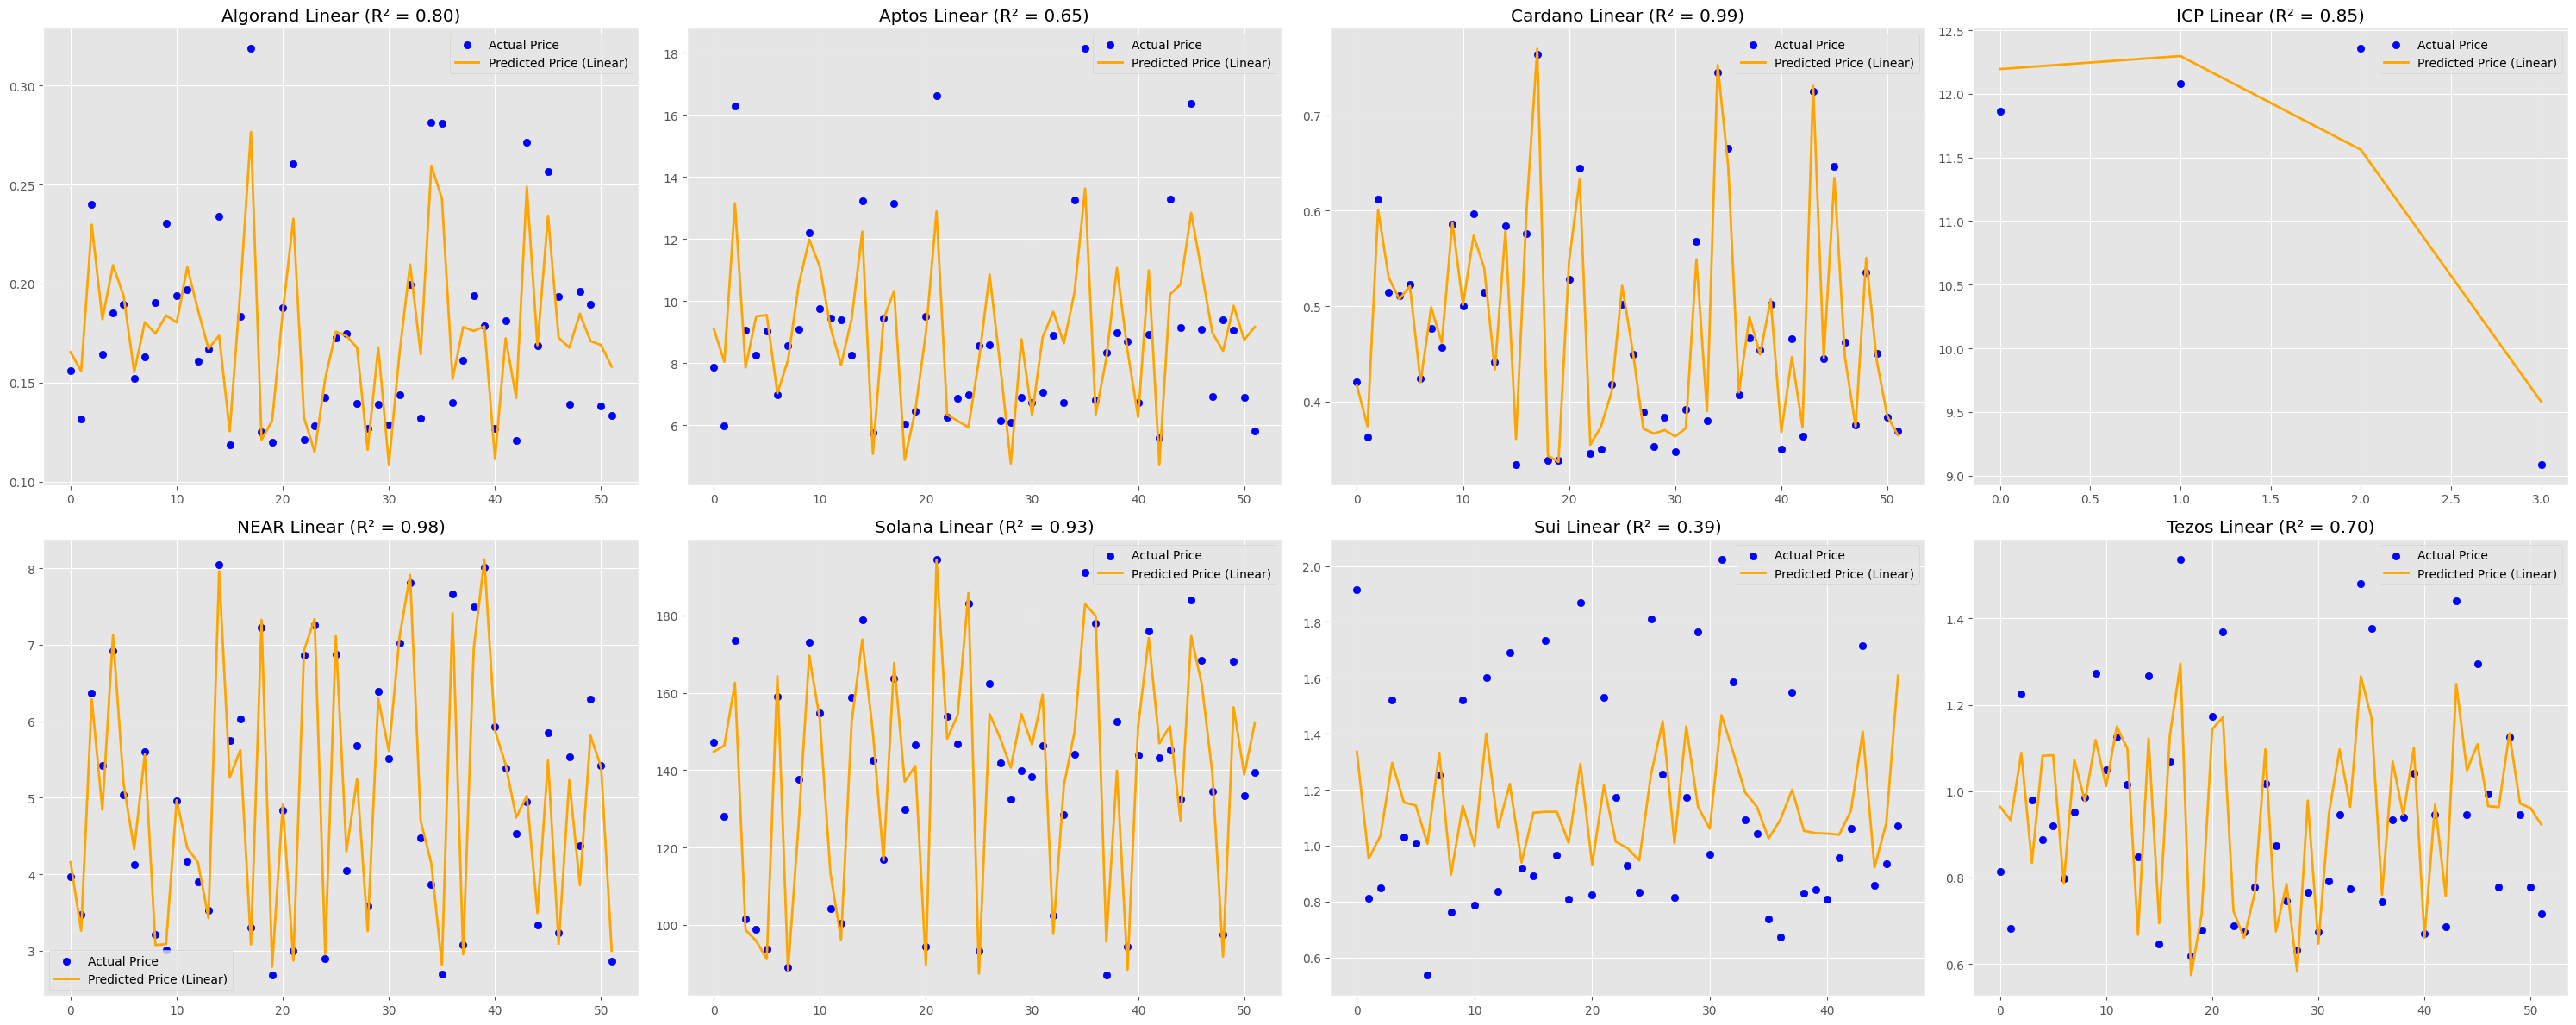

Equation for Algorand: Equation for Algorand (Linear): y = 1.37e-01 + 3.64e-10 * x_1 + -1.50e-09 * x_2 + 2.01e-02 * x_3 + 1.04e-03 * x_4
Equation for Aptos: Equation for Aptos (Linear): y = 1.23e+01 + 1.36e-08 * x_1 + -1.21e-07 * x_2 + 3.58e-02 * x_3 + 6.31e-02 * x_4
Equation for Cardano: Equation for Cardano (Linear): y = 8.61e-01 + 1.39e-09 * x_1 + 1.79e-09 * x_2 + -3.11e-01 * x_3 + 1.98e-03 * x_4
Equation for ICP: Equation for ICP (Linear): y = 1.12e+01 + 2.34e-08 * x_1 + -2.09e-06 * x_2 + -5.37e-07 * x_3 + -1.51e-01 * x_4
Equation for NEAR: Equation for NEAR (Linear): y = -1.25e-01 + 9.79e-09 * x_1 + -2.00e-09 * x_2 + 1.23e-01 * x_3 + 6.26e-03 * x_4
Equation for Solana: Equation for Solana (Linear): y = 3.63e+01 + 1.47e-08 * x_1 + -1.93e-08 * x_2 + 3.57e+00 * x_3 + 3.65e-01 * x_4
Equation for Sui: Equation for Sui (Linear): y = -1.63e+00 + 2.67e-10 * x_1 + 5.17e-10 * x_2 + 6.59e-01 * x_3 + 1.32e-02 * x_4
Equation for Tezos: Equation for Tezos (Linear): y = -3.59e-01 + 5.91e-09 * x_

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
axes = axes.flatten()

equations = []
for i, token in enumerate(chain_names):
    # Extract features and target
    df = datasets[token]
    df = df[df['StablesMCap'].notna()]
    df = df[df['StakingRewards'].notna()]

    

    X = df[['TVL', 'StablesMCap', 'StakingRewards', 'Liquidity']]
    y = df['price']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit linear regression model
    linear_model = fit_linear_model(X_train, y_train)
    y_pred_linear = linear_model.predict(X_test)
    r2_linear = r2_score(y_test, y_pred_linear)
    
    # Get the coefficients and intercept in scientific notation for linear model
    coeffs = linear_model.coef_
    intercept = linear_model.intercept_
    equation_linear = f'y = {intercept:.2e}'
    for j, coef in enumerate(coeffs):
        equation_linear += f' + {coef:.2e} * x_{j+1}'
    
    # Store equation for linear model
    equations.append(f'Equation for {token} (Linear): {equation_linear}')



    # Plot linear regression
    plot_regression_line(axes[i], X_test, y_test, y_pred_linear, 
                         f'{token} Linear (R² = {r2_linear:.2f})', label='Linear')

plt.tight_layout()
plt.show()

for token, equation in zip(chain_names, equations):
    print(f'Equation for {token}: {equation}')

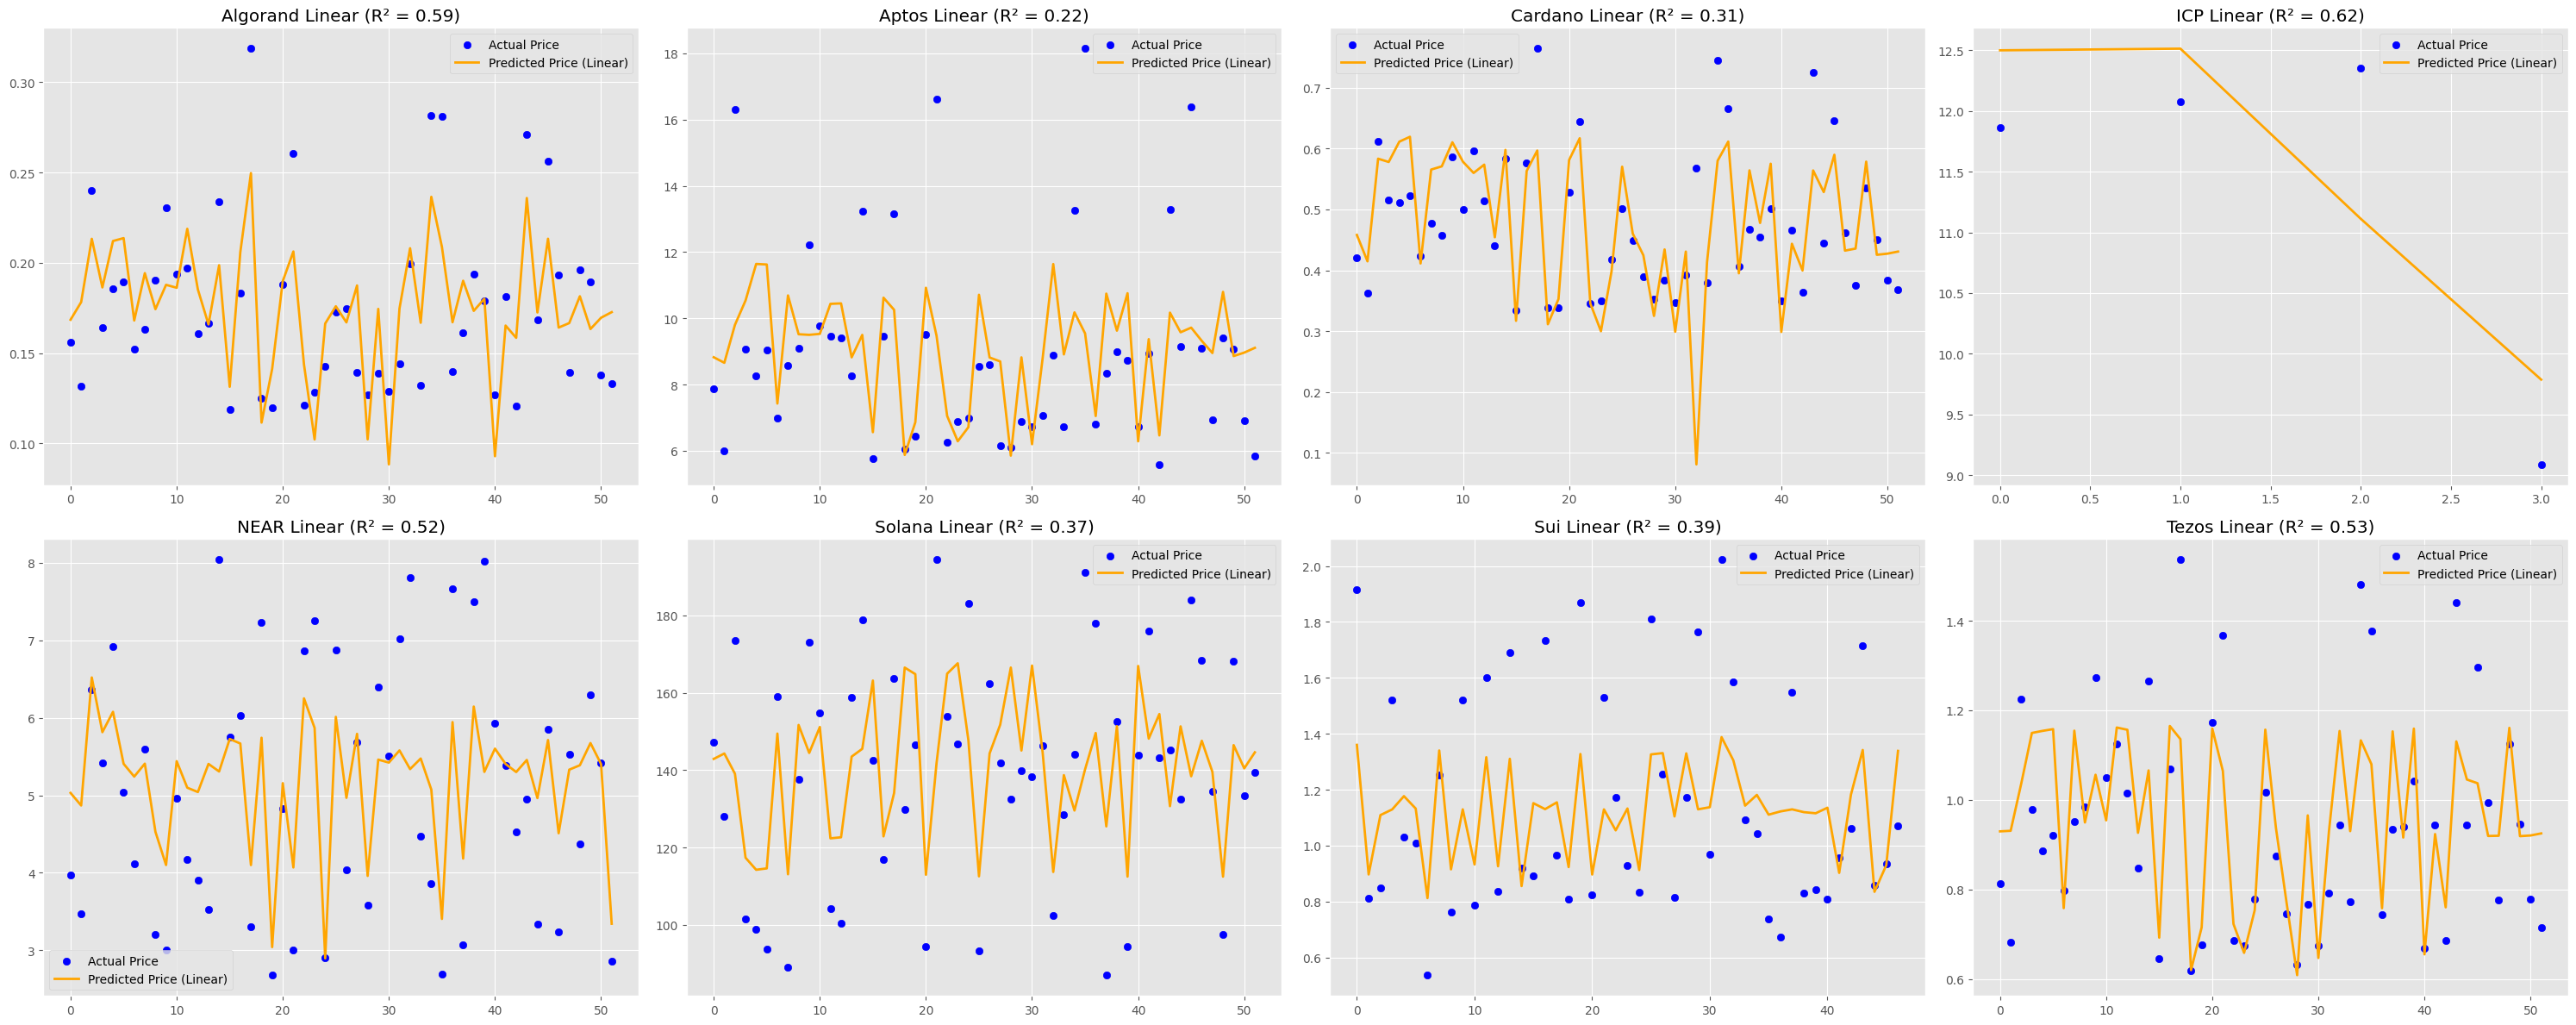

Equation for Algorand: Equation for Algorand (Linear): y = 3.71e-01 + -2.96e-09 * x_1 + 1.04e-02 * x_2
Equation for Aptos: Equation for Aptos (Linear): y = 1.24e+01 + -3.83e-08 * x_1 + 1.47e-01 * x_2
Equation for Cardano: Equation for Cardano (Linear): y = -1.13e+00 + 2.65e-08 * x_1 + 3.89e-01 * x_2
Equation for ICP: Equation for ICP (Linear): y = 1.42e+01 + -4.29e-06 * x_1 + 2.33e-07 * x_2
Equation for NEAR: Equation for NEAR (Linear): y = -1.00e+01 + 1.04e-09 * x_1 + 1.63e+00 * x_2
Equation for Solana: Equation for Solana (Linear): y = 2.47e+01 + 2.66e-08 * x_1 + 5.45e+00 * x_2
Equation for Sui: Equation for Sui (Linear): y = -1.74e+00 + 6.41e-10 * x_1 + 7.96e-01 * x_2
Equation for Tezos: Equation for Tezos (Linear): y = -4.18e-01 + 3.60e-08 * x_1 + -8.05e-02 * x_2


In [63]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
axes = axes.flatten()

equations = []
for i, token in enumerate(chain_names):
    # Extract features and target
    df = datasets[token]
    df = df[df['StablesMCap'].notna()]
    df = df[df['StakingRewards'].notna()]

    

    X = df[['StablesMCap', 'StakingRewards']]
    y = df['price']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit linear regression model
    linear_model = fit_linear_model(X_train, y_train)
    y_pred_linear = linear_model.predict(X_test)
    r2_linear = r2_score(y_test, y_pred_linear)
    
    # Get the coefficients and intercept in scientific notation for linear model
    coeffs = linear_model.coef_
    intercept = linear_model.intercept_
    equation_linear = f'y = {intercept:.2e}'
    for j, coef in enumerate(coeffs):
        equation_linear += f' + {coef:.2e} * x_{j+1}'
    
    # Store equation for linear model
    equations.append(f'Equation for {token} (Linear): {equation_linear}')



    # Plot linear regression
    plot_regression_line(axes[i], X_test, y_test, y_pred_linear, 
                         f'{token} Linear (R² = {r2_linear:.2f})', label='Linear')

plt.tight_layout()
plt.show()

for token, equation in zip(chain_names, equations):
    print(f'Equation for {token}: {equation}')

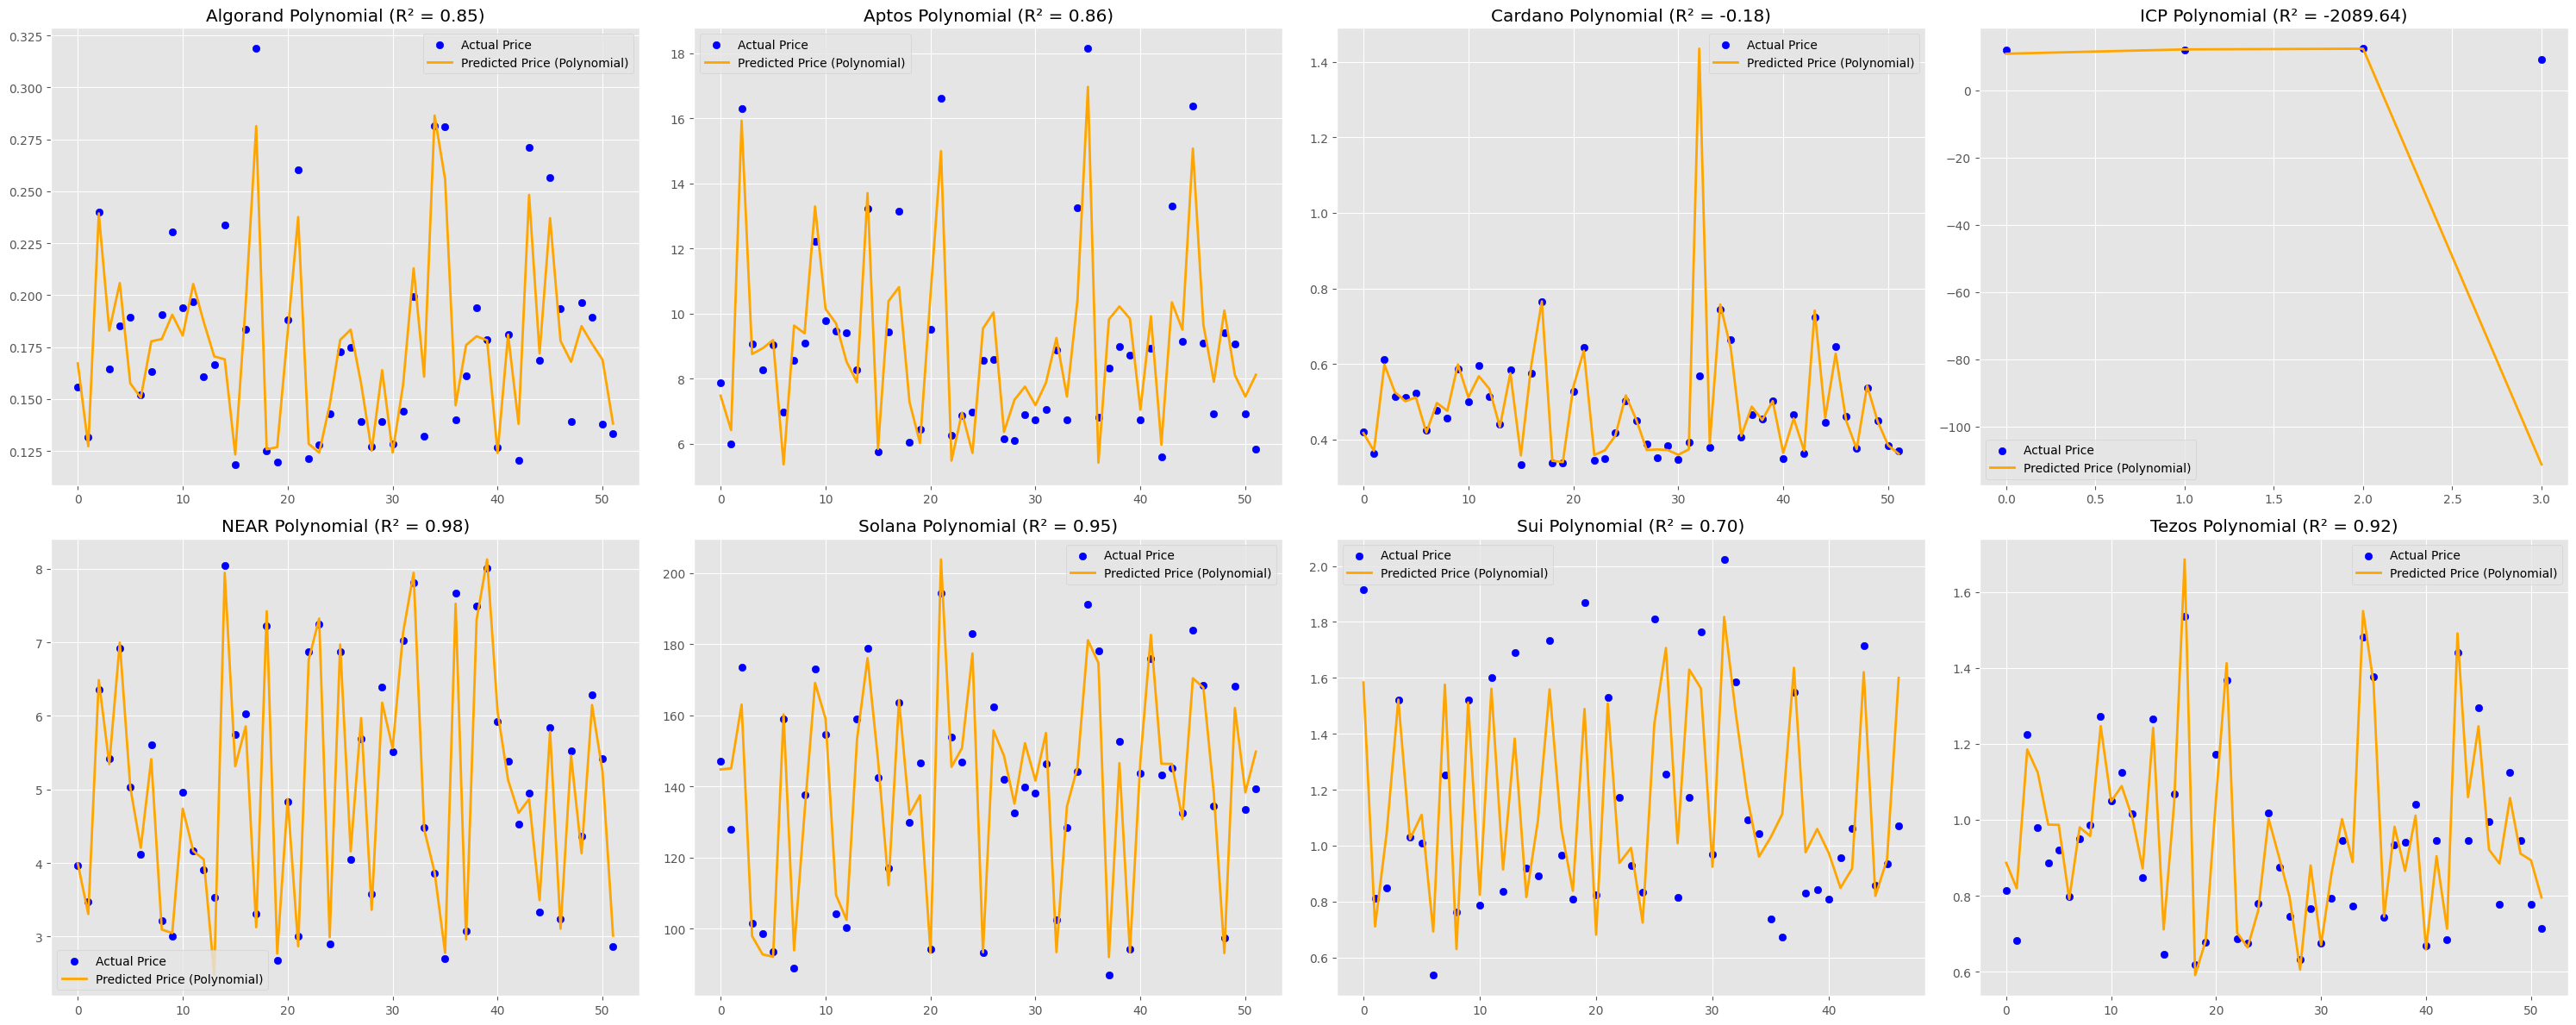

Equation for Algorand: Equation for Algorand (Polynomial): y = 5.17e-01 + -1.82e-09 * x_1 + -6.42e-09 * x_2 + 1.66e-08 * x_3 + -8.93e-08 * x_4 + -1.43e-18 * x_5 + 1.49e-17 * x_6 + 3.16e-10 * x_7 + 3.29e-11 * x_8 + 2.48e-17 * x_9 + -2.60e-10 * x_10 + -2.25e-11 * x_11 + 4.69e-07 * x_12 + 1.77e-06 * x_13 + -1.36e-04 * x_14
Equation for Aptos: Equation for Aptos (Polynomial): y = 2.47e+01 + -5.20e-08 * x_1 + 1.04e-08 * x_2 + -8.20e-15 * x_3 + -3.23e-15 * x_4 + 1.30e-17 * x_5 + -1.84e-16 * x_6 + 1.44e-08 * x_7 + 5.07e-10 * x_8 + 1.62e-15 * x_9 + -8.09e-08 * x_10 + -2.56e-09 * x_11 + -6.76e-14 * x_12 + -6.05e-14 * x_13 + -7.95e-14 * x_14
Equation for Cardano: Equation for Cardano (Polynomial): y = 1.57e-01 + 2.76e-09 * x_1 + 2.05e-09 * x_2 + -1.27e-15 * x_3 + -7.10e-17 * x_4 + 8.77e-19 * x_5 + -8.92e-17 * x_6 + -1.77e-10 * x_7 + 3.32e-11 * x_8 + 2.06e-15 * x_9 + -1.37e-08 * x_10 + -5.46e-10 * x_11 + -9.14e-15 * x_12 + 3.67e-16 * x_13 + -9.34e-14 * x_14
Equation for ICP: Equation for ICP (Pol

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
axes = axes.flatten()

equations_poly = []
for i, token in enumerate(chain_names):
    # Extract features and target
    df = datasets[token]
    
    df = df[df['StablesMCap'].notna()]
    df = df[df['StakingRewards'].notna()]

    
    X = df[['TVL', 'StablesMCap', 'StakingRewards', 'Liquidity']]
    y = df['price']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit polynomial regression model
    poly_model, poly = fit_polynomial_model(X_train, y_train, degree=2)
    X_poly_test = poly.transform(X_test)
    y_pred_poly = poly_model.predict(X_poly_test)
    r2_poly = r2_score(y_test, y_pred_poly)
    
    # Get the coefficients and intercept in scientific notation for polynomial model
    coeffs = poly_model.coef_
    intercept = poly_model.intercept_
    equation_poly = f'y = {intercept:.2e}'
    for j, coef in enumerate(coeffs):
        equation_poly += f' + {coef:.2e} * x_{j+1}'

    # Store equation for linear model
    equations_poly.append(f'Equation for {token} (Polynomial): {equation_poly}')


    # Plot polynomial regression
    plot_regression_line(axes[i], X_test, y_test, y_pred_poly, 
                            f'{token} Polynomial (R² = {r2_poly:.2f})', label='Polynomial')

plt.tight_layout()
plt.show()

for token, equation in zip(chain_names, equations_poly):
    print(f'Equation for {token}: {equation}')


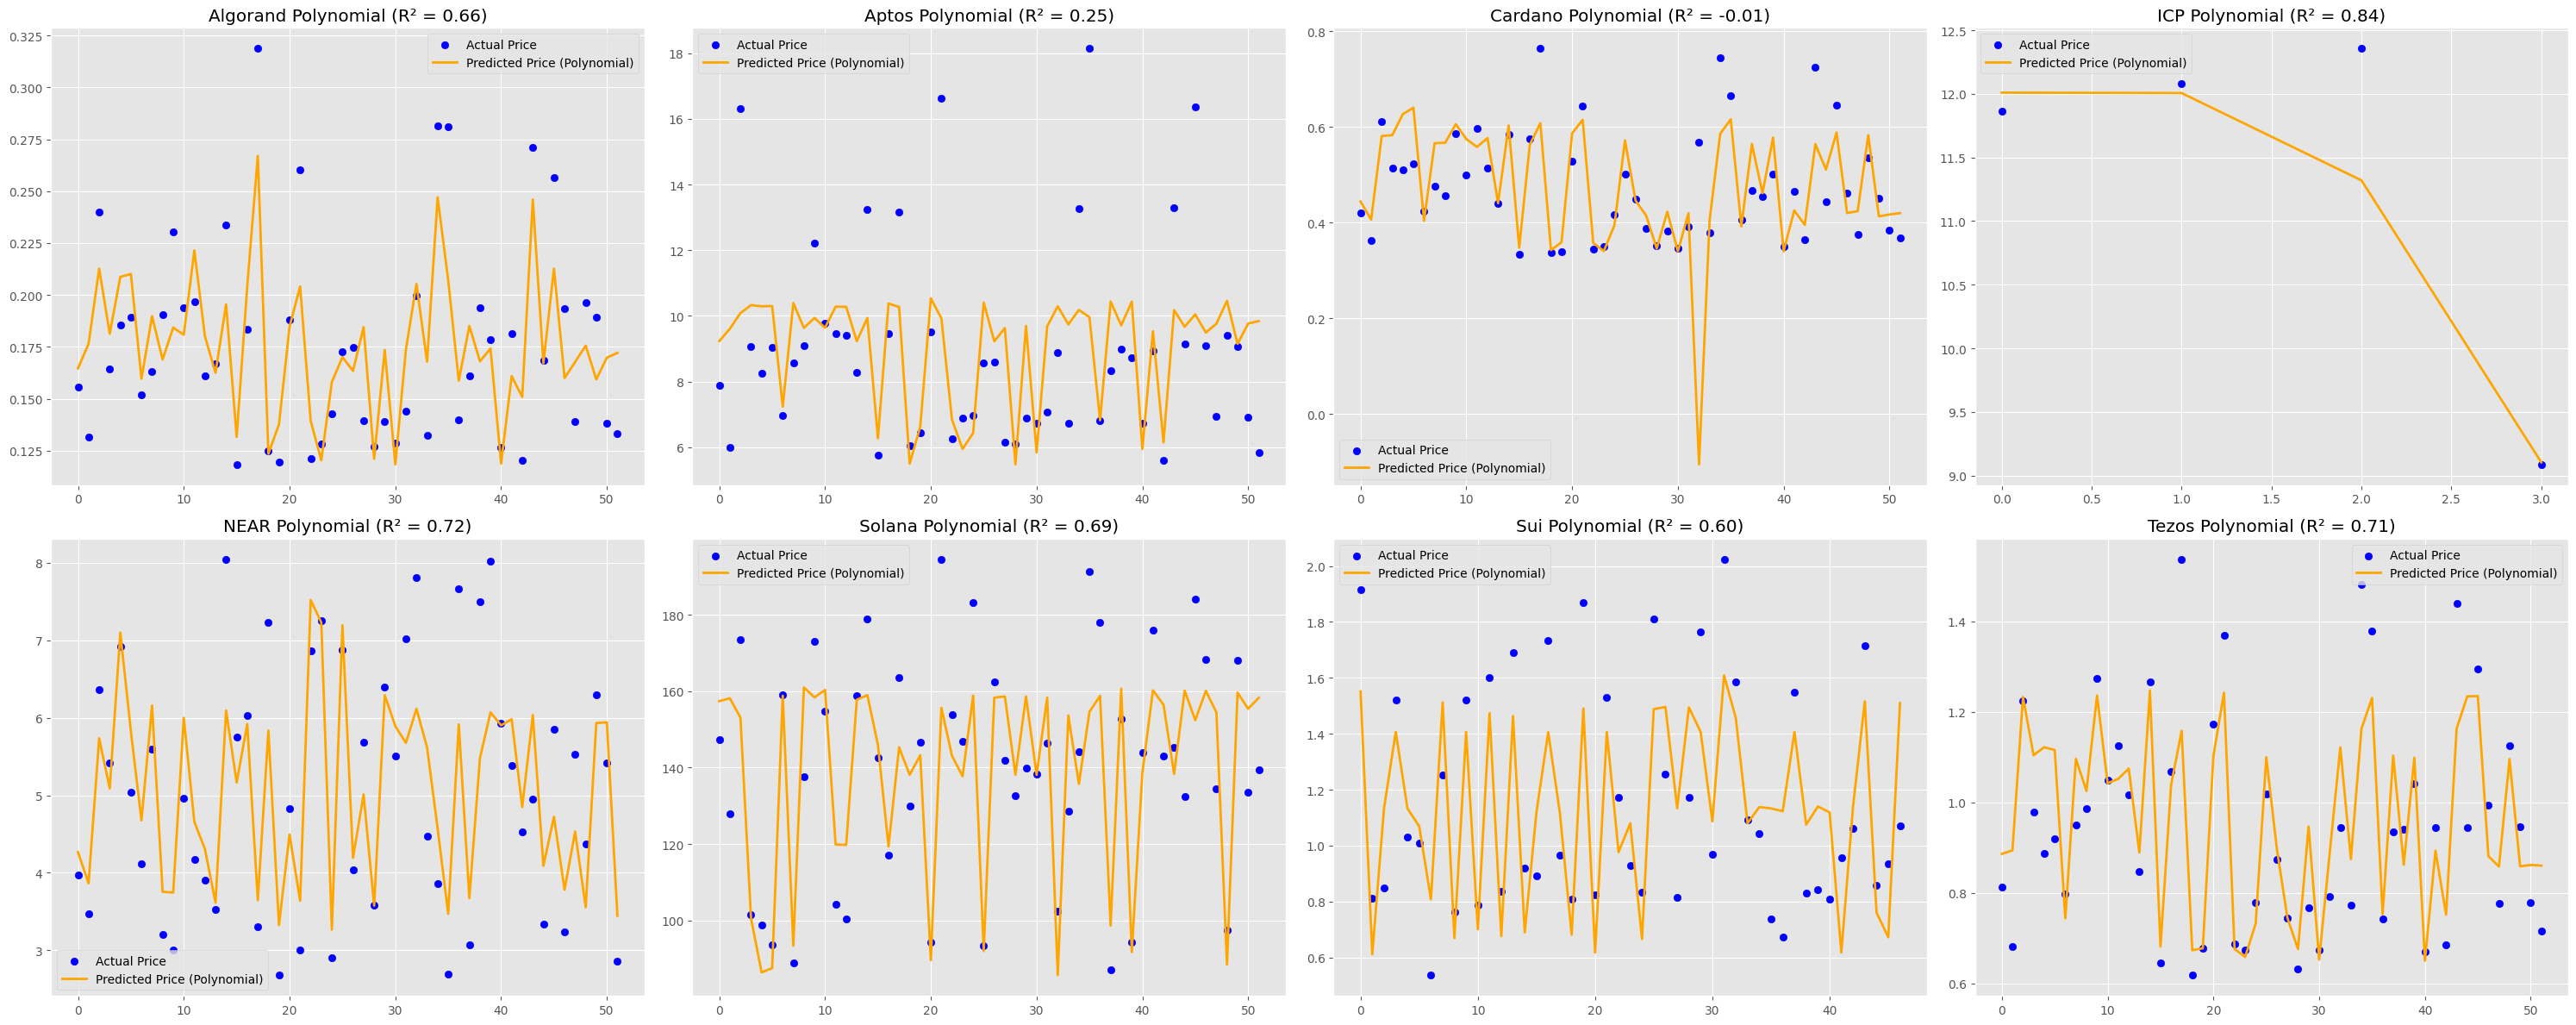

Equation for Algorand: Equation for Algorand (Polynomial): y = 7.69e-01 + -1.26e-08 * x_1 + -4.73e-05 * x_2 + 5.03e-17 * x_3 + 3.41e-10 * x_4 + -1.35e-03 * x_5
Equation for Aptos: Equation for Aptos (Polynomial): y = 1.32e+01 + -8.21e-08 * x_1 + -5.76e-03 * x_2 + -7.37e-17 * x_3 + 1.50e-08 * x_4 + -7.64e-02 * x_5
Equation for Cardano: Equation for Cardano (Polynomial): y = 1.61e+00 + -2.21e-07 * x_1 + -3.31e-02 * x_2 + 1.56e-16 * x_3 + 8.21e-08 * x_4 + -1.68e-01 * x_5
Equation for ICP: Equation for ICP (Polynomial): y = 1.00e+01 + 9.03e-06 * x_1 + 1.13e-05 * x_2 + -1.00e-11 * x_3 + -1.53e-11 * x_4 + -4.24e-12 * x_5
Equation for NEAR: Equation for NEAR (Polynomial): y = 3.03e+00 + -5.41e-08 * x_1 + 1.06e-14 * x_2 + -1.41e-17 * x_3 + 7.37e-09 * x_4 + 4.50e-14 * x_5
Equation for Solana: Equation for Solana (Polynomial): y = -2.48e+02 + 2.45e-07 * x_1 + 8.47e-17 * x_2 + -3.94e-17 * x_3 + 1.19e-09 * x_4 + -2.11e-14 * x_5
Equation for Sui: Equation for Sui (Polynomial): y = 1.41e+00 + -1.63e

In [67]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))
axes = axes.flatten()

equations_poly = []
for i, token in enumerate(chain_names):
    # Extract features and target
    df = datasets[token]
    
    df = df[df['StablesMCap'].notna()]
    df = df[df['StakingRewards'].notna()]

    
    X = df[['StablesMCap', 'StakingRewards']]
    y = df['price']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit polynomial regression model
    poly_model, poly = fit_polynomial_model(X_train, y_train, degree=2)
    X_poly_test = poly.transform(X_test)
    y_pred_poly = poly_model.predict(X_poly_test)
    r2_poly = r2_score(y_test, y_pred_poly)
    
    # Get the coefficients and intercept in scientific notation for polynomial model
    coeffs = poly_model.coef_
    intercept = poly_model.intercept_
    equation_poly = f'y = {intercept:.2e}'
    for j, coef in enumerate(coeffs):
        equation_poly += f' + {coef:.2e} * x_{j+1}'

    # Store equation for linear model
    equations_poly.append(f'Equation for {token} (Polynomial): {equation_poly}')


    # Plot polynomial regression
    plot_regression_line(axes[i], X_test, y_test, y_pred_poly, 
                            f'{token} Polynomial (R² = {r2_poly:.2f})', label='Polynomial')

plt.tight_layout()
plt.show()

for token, equation in zip(chain_names, equations_poly):
    print(f'Equation for {token}: {equation}')
